In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
 
# PyTorch画像用
import torchvision
import torchvision.transforms as transforms
 
# 画像表示用
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
 
# データセットの取得
train_dataset = torchvision.datasets.MNIST(
    root='./datasets',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
# DataLoaderの作成
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

In [3]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev


In [4]:
class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

In [5]:
class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev

In [6]:
def loss_function(label, predict, mu, log_var):
  reconstruction_loss = F.binary_cross_entropy(predict, label, reduction='sum')
  kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss, reconstruction_loss, kl_loss

In [7]:
image_size = 28 * 28
h_dim = 32
z_dim = 2
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [29]:
losses = []
model.train()
mu_history = []
labels_history = []
for epoch in range(num_epochs):
  train_loss = 0
  for i, (x, labels) in enumerate(train_loader):
    # 予測
    x = x.to(device).view(-1, image_size).to(torch.float32)
    x_recon, mu, log_var, z = model(x)
    mu_history.append(mu)
    labels_history.append(labels)
    # 損失関数の計算
    loss, recon_loss, kl_loss = loss_function(x, x_recon, mu, log_var)
     
    # パラメータの更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    # 損失の表示
    if (i+1) % 10 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}, reconstruct loss: {recon_loss: 0.4f}, KL loss: {kl_loss: 0.4f}')
    losses.append(loss)

Epoch: 1, loss:  18225.3027, reconstruct loss:  18111.2148, KL loss:  114.0874
Epoch: 1, loss:  17438.3809, reconstruct loss:  17353.7637, KL loss:  84.6177
Epoch: 1, loss:  18893.8750, reconstruct loss:  18813.8242, KL loss:  80.0504
Epoch: 1, loss:  17875.5684, reconstruct loss:  17802.5723, KL loss:  72.9955
Epoch: 1, loss:  18012.4023, reconstruct loss:  17930.5117, KL loss:  81.8912
Epoch: 1, loss:  18114.9023, reconstruct loss:  18028.9004, KL loss:  86.0029
Epoch: 1, loss:  17825.3672, reconstruct loss:  17734.8652, KL loss:  90.5014
Epoch: 1, loss:  17943.7695, reconstruct loss:  17860.0742, KL loss:  83.6949
Epoch: 1, loss:  17490.9902, reconstruct loss:  17408.5625, KL loss:  82.4284
Epoch: 1, loss:  17219.9941, reconstruct loss:  17144.0312, KL loss:  75.9620
Epoch: 1, loss:  17247.3965, reconstruct loss:  17170.1602, KL loss:  77.2358
Epoch: 1, loss:  18783.4453, reconstruct loss:  18706.0449, KL loss:  77.4000
Epoch: 1, loss:  16888.7051, reconstruct loss:  16802.6055, KL 

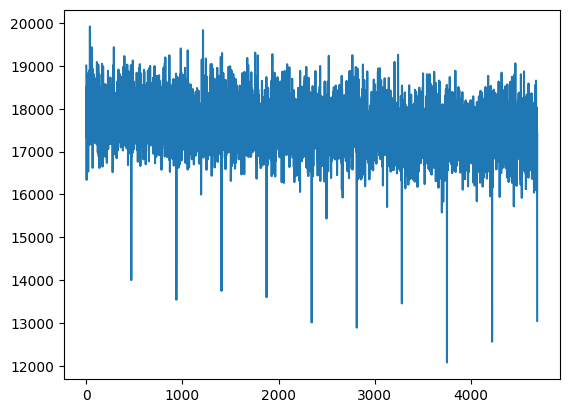

In [30]:
train_loss_tensor = torch.stack(losses)
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

In [31]:
sliced_tensors = [tensor.detach().numpy().tolist() for tensor in mu_history][0]

In [33]:
labels_tensors = [tensor.detach().numpy().tolist() for tensor in labels_history][0]

In [35]:
labels_tensors

[5,
 8,
 8,
 7,
 9,
 6,
 3,
 8,
 6,
 3,
 5,
 0,
 0,
 7,
 7,
 8,
 9,
 5,
 7,
 4,
 9,
 1,
 1,
 6,
 9,
 2,
 4,
 9,
 5,
 3,
 2,
 3,
 4,
 6,
 6,
 9,
 2,
 0,
 2,
 5,
 5,
 5,
 6,
 3,
 7,
 3,
 8,
 6,
 0,
 6,
 7,
 2,
 9,
 5,
 8,
 4,
 7,
 2,
 6,
 1,
 1,
 6,
 2,
 3,
 4,
 0,
 6,
 8,
 1,
 2,
 5,
 4,
 3,
 0,
 1,
 4,
 6,
 1,
 9,
 2,
 9,
 2,
 0,
 7,
 7,
 2,
 7,
 7,
 7,
 0,
 0,
 8,
 8,
 6,
 2,
 7,
 8,
 7,
 5,
 2,
 1,
 5,
 0,
 6,
 7,
 4,
 5,
 3,
 8,
 1,
 1,
 9,
 4,
 6,
 0,
 1,
 2,
 4,
 9,
 4,
 8,
 9,
 4,
 6,
 0,
 5,
 6,
 5]

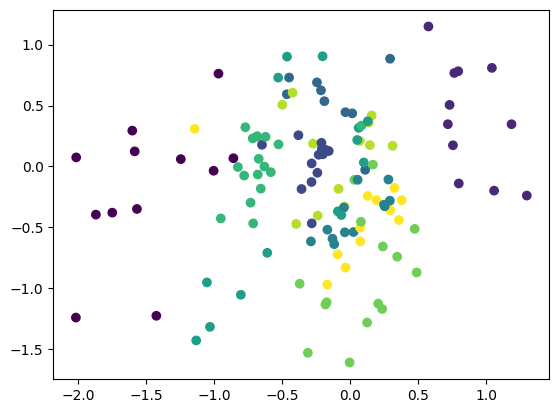

In [36]:
import numpy as np
mu = np.array(sliced_tensors)
plt.scatter(mu[:, 0], mu[:, 1], c=labels_tensors)
